##  Class of data preprocessing

In [70]:
import pandas as pd
import numpy as np

class Data_Preprocessing():
    
    def __init__(self, prefix = '../../data/'):
        self.prefix = prefix
        self.diagnoses = None
        self.measures = None
    
    # Descriptions of different kinds of diseases based on ICD_CODE
    def get_icd9codes(self,filename='D_ICD_DIAGNOSES.csv'):
        icd9_code_df = pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
        return icd9_code_df

    # Information about what diseases patients are diagnosed
    def read_diagnoses(self,filename='DIAGNOSES_ICD.csv',
                       link_filename = 'D_ICD_DIAGNOSES.csv',link_field='ICD9_CODE',
                      columns = ['SUBJECT_ID','ICD9_CODE','SHORT_TITLE','LONG_TITLE']):
        diagnose_df = pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
        diagnose_df = pd.merge(diagnose_df, self.get_icd9codes(link_filename), how='left', on=[link_field])
        self.diagnoses = diagnose_df[columns]
        
    # Pick data of specific diseases from diagnoses data
    # 4280 Congestive heart failure
    def get_labels(self, label_filed = 'ICD9_CODE', labels = ['4280'], user_field = 'SUBJECT_ID'):
        if self.diagnoses is None:
            print('Please use read_diagnoses function to get diagnose data first')
            return False
        else:
            ## TODO: What if it is required to process multiple diseases?
            filtered_diseass = self.diagnoses[self.diagnoses[label_filed].isin(labels)].drop_duplicates()
            filtered_diseass['LABEL'] = 1
            return filtered_diseass[[user_field,'LABEL']]
        
    
    # Descriptions of different kinds of clinical measurements
    def get_measure_items(self,filename='D_LABITEMS.csv'):
        measure_items_df = pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
        return measure_items_df
    
    # Information about what measurements patients have and values of those measurements -> attributes
    def read_measurements(self,filename = 'LABEVENTS.csv',\
                          columns = ['SUBJECT_ID','VALUE','VALUENUM','LABEL'],\
                          link = 'ITEMID', topN = 30):
        measurements_df = pd.read_csv(self.prefix+filename, sep=',', encoding='latin1')
        measurements_df = pd.merge(measurements_df, self.get_measure_items(), how='left', on=[link])[columns]
        
        label, value = columns[3], columns[1]
        ## Count frequency of each laebl
        label_mostfreq_df = measurements_df.dropna(subset=[value]).groupby(label).size().\
        reset_index(name='counts').sort_values(ascending=0,by='counts')[:topN][label]
        
        measurements_df = measurements_df[measurements_df[label].isin(label_mostfreq_df)]
        self.measures = measurements_df
    
    # min_null: fields with none values more than 80% are categorical fields, otherwise continous fields.
    def get_uservectors_dict(self, fields= ['VALUE','LABEL','VALUENUM','SUBJECT_ID'], min_nulls = 0.8):
        value = fields[0]
        label = fields[1]
        valuenum = fields[2]
        userid = fields[3]
        labels_nulls = self.measures.dropna(subset=[value]).groupby(label)[valuenum].apply(lambda x: x.isnull().sum())
        
        # initiate all user vectors
        len_all_measures = len(self.measures)
        stc_ls = ['min','mean','max','std']
        stc_ls_len = len(stc_ls)
        user_vectors = {}
        all_users = set(self.measures[userid].unique())
        for user in all_users:
            user_vectors[user] = np.empty([0])
            
        # Groupby label
        measure_label = self.measures.groupby(label)

        for label, label_df in measure_label:

            print("label", label," start:", len(user_vectors[0]))
            if ((labels_nulls[label]/len_all_measures)<min_nulls):
                # pick one iteration of continuous label
                label_df = label_df.dropna(subset=[valuenum])

                missed_users = all_users -set(label_df[userid].unique())
                label_df_agg = label_df.groupby(userid)[valuenum].agg(stc_ls)

                for user, row in label_df_agg.iterrows():
                    if pd.isnull(row['std']): row['std']=0
                    user_vectors[user]=np.append(user_vectors[user],[row[x] for x in stc_ls])
                for user in missed_users:
                    user_vectors[user]=np.append(user_vectors[user],np.full(stc_ls_len, np.nan))
            
            else:
                # pick one iteration of discrete label
                label_df = label_df.dropna(subset=[value])
                missed_users = all_users - set(label_df[user].unique())
                label_df_agg = label_df.groupby([userid,value])[label].agg(['count'])
                label_df_agg_per = label_df_agg.groupby(level=0).apply(lambda x: 100* x/float(x.sum()))

                label_df_agg_per.reset_index
                label_matrix = pd.pivot_table(label_df_agg_per,
                                              values = ['count'],index=[userid],columns=[value]).fillna(0)

                for user in label_matrix.index.get_level_values(userid):
                    user_vectors[user] = np.append(user_vectors[user],label_matrix.ix[user].values)
                for user in missed_users:
                    user_vectors[user]=np.append(user_vectors[user],np.full(label_matrix.shape[1], np.nan))

            print(" end:", len(user_vectors[0]))
                    
        return user_vectors
                

## read diagnose information

In [ ]:
# data_preprocessing = Data_Preprocessing()
# data_preprocessing.read_diagnoses()
# data_preprocessing.diagnoses.head()

In [ ]:
# data_preprocessing.get_labels().head()

## Feature Data (Use Labevents rather than Charevents)

In [19]:
data_preprocessing = Data_Preprocessing()
data_preprocessing.read_measurements()
data_preprocessing.measures.head()
user_vectors = data_preprocessing.get_user_vectors()
# labevent_items_df = pd.read_csv('../../data/D_LABITEMS.csv', sep=',', encoding='latin1')
# labevent_cols = ['SUBJECT_ID','VALUE','VALUENUM','LABEL']
# labevent_detailed_df = pd.merge(labevent_df, labevent_items_df, how='left', on=['ITEMID'])[labevent_cols]
# labevent_detailed_df.sort_values(by='SUBJECT_ID')[:10]

In [14]:
data_preprocessing.measures.dropna(subset=['VALUE']).groupby('LABEL').size().reset_index(name='counts').\
sort_values(ascending=0,by='counts')[:30]

,LABEL,counts
8,Glucose,1046900
9,Hematocrit,881766
20,Potassium,845736
10,Hemoglobin,842156
24,Sodium,808399
6,Creatinine,797389
5,Chloride,795479
25,Urea Nitrogen,791838
2,Bicarbonate,780644
19,Platelet Count,778364


In [20]:
user_vectors[775]
# Assign index to measurement item

# label_array = labevent_detailed_df['LABEL'].unique() 
# label_map = {}

# for i in range(0,len(label_array)):
#     label_map[label_array[i]] = i


array([1.50000000e+01, 1.70000000e+01, 1.90000000e+01, 1.63299316e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.90000000e+01, 2.07500000e+01, 2.30000000e+01, 2.06155281e+00,
                  nan,            nan,            nan,            nan,
       2.50000000e+01, 2.75000000e+01, 3.00000000e+01, 3.53553391e+00,
       1.02000000e+02, 1.05400000e+02, 1.11000000e+02, 3.43511281e+00,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       4.07000000e+01, 4.33000000e+01, 4.59000000e+01, 3.67695526e+00,
       1.39000000e+01, 1.47000000e+01, 1.55000000e+01, 1.13137085e+00,
                  nan,            nan,            nan,            nan,
       2.96000000e+01, 3.01500000e+01, 3.07000000e+01, 7.77817459e-01,
       3.37000000e+01, 3.39500000e+01, 3.42000000e+01, 3.53553391e-01,
      

In [29]:
# user_vectors[2]
user_dataframe = pd.DataFrame(user_vectors).T.dropna(axis=0,how='all')
user_dataframe[:10]
# dctToNdarray
# pd.DataFrame({'SS':test.index})

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.0,14.705882,23.0,2.713931,-12.0,-4.266667,6.0,3.774315,11.0,22.085714,...,50.0,5.690502,5.0,7.020172,7.59,0.844257,20.0,114.955556,329.0,76.154137
4,13.0,16.191489,24.0,2.091788,-5.0,-3.000000,-1.0,2.828427,16.0,23.638298,...,28.0,0.707107,5.0,6.519000,7.47,0.892655,42.0,58.000000,74.0,22.627417
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10.0,16.406250,23.0,3.057085,-9.0,-4.400000,0.0,4.037326,14.0,20.625000,...,44.0,5.263079,5.0,5.980667,7.41,1.118535,104.0,127.400000,153.0,20.791825
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10.0,12.571429,14.0,1.272418,-1.0,-0.285714,1.0,0.726273,21.0,24.142857,...,67.0,10.171064,5.0,7.303125,8.00,0.635250,68.0,119.500000,381.0,81.651935
10,17.0,18.000000,19.0,1.414214,NaN,NaN,NaN,NaN,18.0,20.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12.0,14.333333,17.0,1.568929,2.0,2.000000,2.0,0.000000,25.0,26.777778,...,30.0,0.000000,5.0,6.130000,7.52,1.321968,222.0,222.000000,222.0,0.000000


In [145]:
MAX_NULLS = 0.5
user_dataframe['NULL%'] = user_dataframe.isnull().sum(axis=1)/user_dataframe.shape[1]

In [155]:
## Drop rows with too many null values
user_cleandf = user_dataframe[user_dataframe['NULL%']<MAX_NULLS]
user_cleandf = user_cleandf.drop(['NULL%'],axis=1)
user_cleandf[:10]

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
3,9.0,14.705882,23.0,2.713931,-12.0,-4.266667,6.0,3.774315,11.0,22.085714,...,50.0,5.690502,5.00,7.020172,7.59,0.844257,20.0,114.955556,329.0,76.154137
4,13.0,16.191489,24.0,2.091788,-5.0,-3.000000,-1.0,2.828427,16.0,23.638298,...,28.0,0.707107,5.00,6.519000,7.47,0.892655,42.0,58.000000,74.0,22.627417
6,10.0,16.406250,23.0,3.057085,-9.0,-4.400000,0.0,4.037326,14.0,20.625000,...,44.0,5.263079,5.00,5.980667,7.41,1.118535,104.0,127.400000,153.0,20.791825
9,10.0,12.571429,14.0,1.272418,-1.0,-0.285714,1.0,0.726273,21.0,24.142857,...,67.0,10.171064,5.00,7.303125,8.00,0.635250,68.0,119.500000,381.0,81.651935
11,12.0,14.333333,17.0,1.568929,2.0,2.000000,2.0,0.000000,25.0,26.777778,...,30.0,0.000000,5.00,6.130000,7.52,1.321968,222.0,222.000000,222.0,0.000000
12,9.0,14.125000,28.0,4.514791,-22.0,-4.700000,7.0,9.131794,11.0,22.812500,...,63.0,6.572321,5.00,7.186970,7.51,0.583794,7.0,137.766667,340.0,74.611954
13,8.0,13.450000,17.0,2.818641,-6.0,-1.461538,3.0,2.536907,23.0,26.809524,...,47.0,5.664781,5.00,7.030000,7.51,0.745728,101.0,244.769231,399.0,109.796899
17,9.0,13.133333,20.0,2.642149,-11.0,-4.200000,0.0,3.098387,18.0,24.352941,...,167.0,33.205995,6.88,7.253333,7.43,0.169243,67.0,198.800000,376.0,103.056988
18,13.0,15.714286,18.0,1.799471,3.0,3.000000,3.0,0.000000,23.0,25.857143,...,29.0,0.000000,6.50,7.013333,7.54,0.520128,198.0,198.000000,198.0,0.000000
19,15.0,17.000000,20.0,2.160247,0.0,0.000000,0.0,0.000000,21.0,21.750000,...,36.0,0.000000,6.50,6.955000,7.41,0.643467,116.0,116.000000,116.0,0.000000


## MICE Imputation

In [162]:
#############################################################
## MICE imputation
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [158]:
## TODO: check wired columns with all null values, [92,93,94,95]
user_cleandf = user_cleandf.dropna(axis=1, how='all')
user_cleandf.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
count,40382.00,40382.00,40382.00,40382.00,31111.00,31111.00,31111.00,31111.00,40389.00,40389.00,...,31108.00,31108.00,37798.00,37798.00,37798.00,37798.00,31108.00,31108.00,31108.00,31108.00
mean,10.43,13.82,18.31,2.36,-4.35,-0.49,3.05,2.29,20.53,25.19,...,52.08,5.42,5.77,6.88,7.36,0.57,82.33,152.60,275.69,63.37
std,2.96,2.73,5.04,1.27,8.20,5.31,6.27,2.33,4.52,3.55,...,16.83,4.53,0.98,0.62,0.65,0.45,62.33,78.27,149.31,51.43
min,-21.00,3.00,4.00,0.00,-414.00,-414.00,-414.00,0.00,2.00,6.00,...,10.00,0.00,0.00,1.00,1.00,0.00,0.00,10.00,10.00,0.00
25%,9.00,12.11,15.00,1.68,-7.00,-2.05,0.00,1.00,18.00,23.33,...,42.00,2.83,5.00,6.62,7.38,0.12,43.00,96.82,143.00,20.41
50%,10.00,13.46,17.00,2.20,-3.00,0.00,3.00,2.06,21.00,25.33,...,49.00,4.97,5.00,7.11,7.46,0.56,68.00,135.24,263.00,53.69
75%,12.00,15.00,20.00,2.83,0.00,1.50,6.00,3.20,23.00,27.14,...,57.00,7.08,6.50,7.30,7.51,0.89,97.00,197.38,409.00,103.42
max,44.00,49.00,118.00,30.11,24.00,26.50,162.00,204.36,52.00,52.00,...,247.00,98.99,9.00,9.00,11.00,3.89,630.00,630.00,1914.00,443.36


In [159]:
user_cleandf.isna().sum(axis=0)

0        153
1        153
2        153
3        153
4       9424
5       9424
6       9424
7       9424
8        146
9        146
10       146
11       146
12      2565
13      2565
14      2565
15      2565
16      9424
17      9424
18      9424
19      9424
20       138
21       138
22       138
23       138
24      1222
25      1222
26      1222
27      1222
28     15630
29     15630
       ...  
86        14
87        14
88        10
89        10
90        10
91        10
96       137
97       137
98       137
99       137
100     1210
101     1210
102     1210
103     1210
104        7
105        7
106        7
107        7
108     9427
109     9427
110     9427
111     9427
112     2737
113     2737
114     2737
115     2737
116     9427
117     9427
118     9427
119     9427
Length: 116, dtype: int64

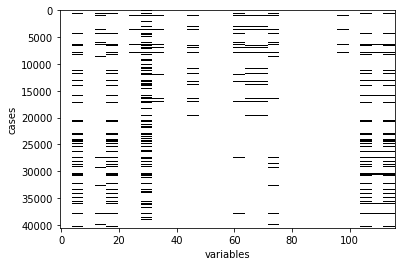

In [160]:
plt.imshow(~user_cleandf.isna(), aspect='auto')
plt.xlabel("variables")
plt.ylabel("cases")
plt.gray()
plt.show()

In [168]:
## For mice model, column name should be string instead of numeric type.
user_cleandf.columns = ['X'+str(i) for i in user_cleandf.columns]

In [177]:
'hanning%s.pdf' % 'fd'

'hanningfd.pdf'

In [183]:
import statsmodels.imputation.mice as smi
formula = 'X0 - ' + ' + '.join(user_cleandf.columns[1:])
print("The formula for MICE is \"%s\"]." % formula)
imp = smi.MICEData(user_cleandf)
mmod = smi.MICE(formula, sm.OLS, imp)

The formula for MICE is "X0 - X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12 + X13 + X14 + X15 + X16 + X17 + X18 + X19 + X20 + X21 + X22 + X23 + X24 + X25 + X26 + X27 + X28 + X29 + X30 + X31 + X32 + X33 + X34 + X35 + X36 + X37 + X38 + X39 + X40 + X41 + X42 + X43 + X44 + X45 + X46 + X47 + X48 + X49 + X50 + X51 + X52 + X53 + X54 + X55 + X56 + X57 + X58 + X59 + X60 + X61 + X62 + X63 + X64 + X65 + X66 + X67 + X68 + X69 + X70 + X71 + X72 + X73 + X74 + X75 + X76 + X77 + X78 + X79 + X80 + X81 + X82 + X83 + X84 + X85 + X86 + X87 + X88 + X89 + X90 + X91 + X96 + X97 + X98 + X99 + X100 + X101 + X102 + X103 + X104 + X105 + X106 + X107 + X108 + X109 + X110 + X111 + X112 + X113 + X114 + X115 + X116 + X117 + X118 + X119 "].


In [184]:
results = mmod.fit(10, 10)

KeyboardInterrupt: 

In [ ]:
############################################################################################################

In [61]:
## Fill na with means
## TODO imputation
user_finaldf = user_cleandf.fillna(user_cleandf.mean())
user_finaldf.head()
user_finaldf.columns[user_finaldf.isnull().any()]
# any(np.isnan(user_cleandf.fillna(0)))

Index([92, 93, 94, 95], dtype='object')

In [37]:
data_preprocessing.read_diagnoses()
actual_label = data_preprocessing.get_labels()
actual_label.sort_values(by='SUBJECT_ID').head()

,SUBJECT_ID,LABEL
616,3,1
651,9,1
724,21,1
793,26,1
844,34,1


In [49]:
## get labels for patients in measurement data
all_users_list = pd.DataFrame({'SUBJECT_ID': user_finaldf.index})

actual_labels = pd.merge(all_users_list,actual_label,how='left',on='SUBJECT_ID')
len(actual_labels)
actual_labels = actual_labels.fillna(0)
actual_labels.head()

,SUBJECT_ID
0,3
1,4
2,6
3,9
4,11


In [44]:
len(all_users_list)

40141

## Train cluster model

In [72]:
from sklearn.cluster import KMeans

# TODO: check 4 labels remove null values, 4 columns
user_finaldf = user_finaldf.dropna(axis=1)

kmeans = KMeans(n_clusters=2, random_state=0).fit(user_finaldf)
kmeans.labels_

kmeans.cluster_centers_

y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(user_finaldf)
y_pred
from collections import Counter
Counter(y_pred).values()
# list(set(y_pred))

dict_values([37342, 2799])

## Embedding and Plotting

In [76]:
## TSNE is too slow

# from sklearn.manifold import TSNE
# X_embedded = TSNE(n_components=2, learning_rate=3000).fit_transform(user_cleandf)

# plt.figure(figsize=(15, 15))
# plt.scatter(X_embedded[:,0],X_embedded[:,1],c=y_pred)
# plt.title("KMeans")
# plt.show()

In [74]:
## all data
import umap
# from sklearn.datasets import load_digits

# digits = load_digits()

embedding = umap.UMAP().fit_transform(user_finaldf)

actual_labels['LABEL'] = actual_labels['LABEL'].astype(int)
actual_labels['PREDICTED']=y_pred
actual_labels['X0']=embedding[:,0]
actual_labels['X1']=embedding[:,1]
# actual_labels[:10]
# pd.concat([y_pred, actual_labels['LABEL'].astype(int)],axis=1).head()
# embedding.tolist()
true_X = actual_labels[actual_labels['LABEL']==0]
false_X = actual_labels[actual_labels['LABEL']==1]
# true_X.head()
# true_X['LABEL'].head()

In [100]:
## randomly select samples for plot
all_user_label_df = user_finaldf
all_user_label_df['ACTUAL'] = actual_labels['LABEL']
all_user_label_df['PRED'] = y_pred
all_label_df = all_user_label_df.dropna(axis =0)

In [103]:
heart_failure_df = all_label_df[all_label_df['ACTUAL']==1].sample(frac=0.3)
normal_df = all_label_df[all_label_df['ACTUAL']==0].sample(frac=0.15)
random_sample_df = heart_failure_df.append(normal_df)
random_sample_df.head()

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,ACTUAL,PRED
3496,2.0,12.750000,17.0,3.725799,16.0,19.600000,31.0,4.299871,31.0,41.450000,...,5.0,6.945385,7.44,0.870303,45.0,62.300000,167.0,37.034668,1.0,0
12245,10.0,17.372093,30.0,4.208966,-13.0,-3.373984,4.0,3.689592,13.0,20.116279,...,5.0,7.312977,7.55,0.424622,27.0,121.284553,468.0,68.311788,1.0,0
8508,10.0,12.833333,16.0,2.081666,-1.0,2.071429,4.0,1.730464,25.0,27.416667,...,5.0,7.274643,7.53,0.522093,31.0,208.642857,451.0,148.715323,1.0,0
22359,11.0,14.259259,21.0,2.890204,2.0,2.500000,3.0,0.707107,22.0,28.259259,...,5.0,6.725000,8.00,0.903817,51.0,79.500000,108.0,40.305087,1.0,0
27058,8.0,11.291667,16.0,1.944427,-5.0,-3.600000,-1.0,1.673320,19.0,24.560000,...,5.5,6.640000,7.40,0.825249,95.0,116.400000,146.0,20.647034,1.0,0


In [112]:
random_embedding = umap.UMAP().fit_transform(random_sample_df.drop(['ACTUAL','PRED'],axis=1))

random_label_df = random_sample_df[['ACTUAL','PRED']]
# actual_labels['LABEL'] = actual_labels['LABEL'].astype(int)
# actual_labels['PREDICTED']=y_pred
random_label_df['X0']=random_embedding[:,0]
random_label_df['X1']=random_embedding[:,1]
# actual_labels[:10]
# pd.concat([y_pred, actual_labels['LABEL'].astype(int)],axis=1).head()
# embedding.tolist()
random_true_X = random_label_df[random_label_df['ACTUAL']==0]
random_false_X = random_label_df[random_label_df['ACTUAL']==1]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [120]:
len(random_sample_df)

4610

In [116]:
import matplotlib.pyplot as plt

def plot_cluster(true_X, false_X, PRED = 'PREDICTED'):
    colors = ['b','y']

    # marker=[markers[x] for x in actual_labels['LABEL'].astype(int)]
    plt.figure(figsize=(15, 15))
    # for i in range(len(embedding)):
    #     plt.scatter(embedding[i,0], embedding[i,1], 
    #                 c = colors[y_pred[i]], 
    #                 marker = markers[int(actual_labels['LABEL'][i])])
    # v: Label indicates heart failure
    plt.scatter(true_X['X0'],true_X['X1'],c=[colors[x] for x in true_X[PRED]],marker="v",s=50)
    plt.scatter(false_X['X0'],false_X['X1'],c=[colors[x] for x in false_X[PRED]],marker="+",s=50)
    #             ,marker=actual_labels['LABEL'].astype(int))
    # [markers[x] for x in actual_labels['LABEL'].astype(int)]

    plt.title("KMeans")
    plt.show()

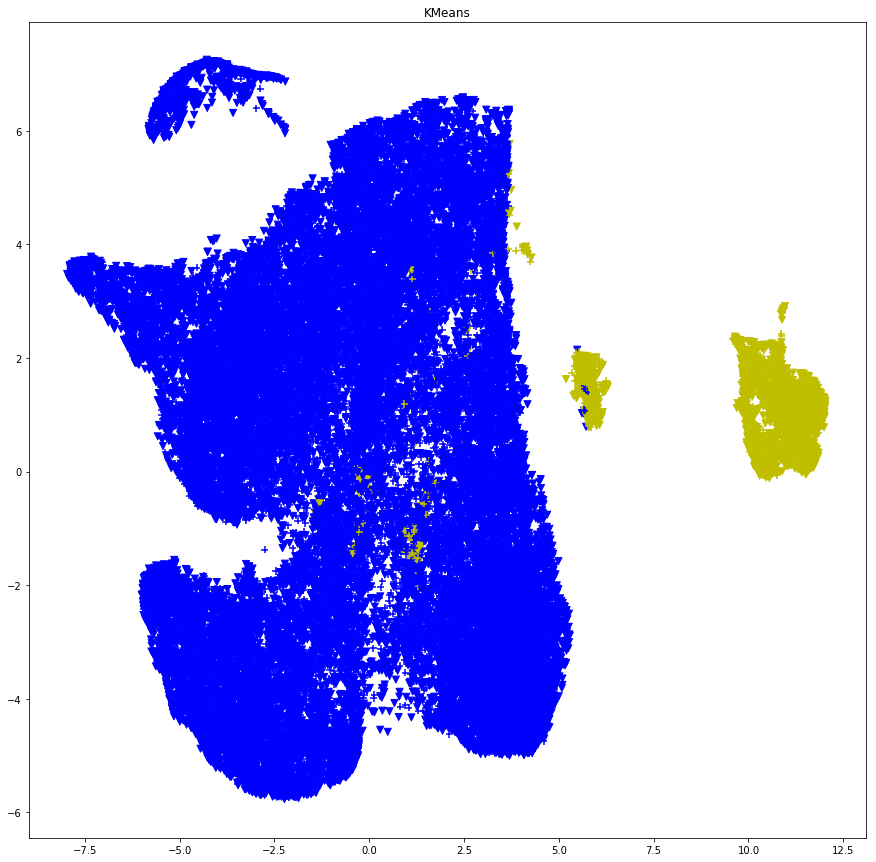

In [88]:
plot_cluster(true_X,false_X)

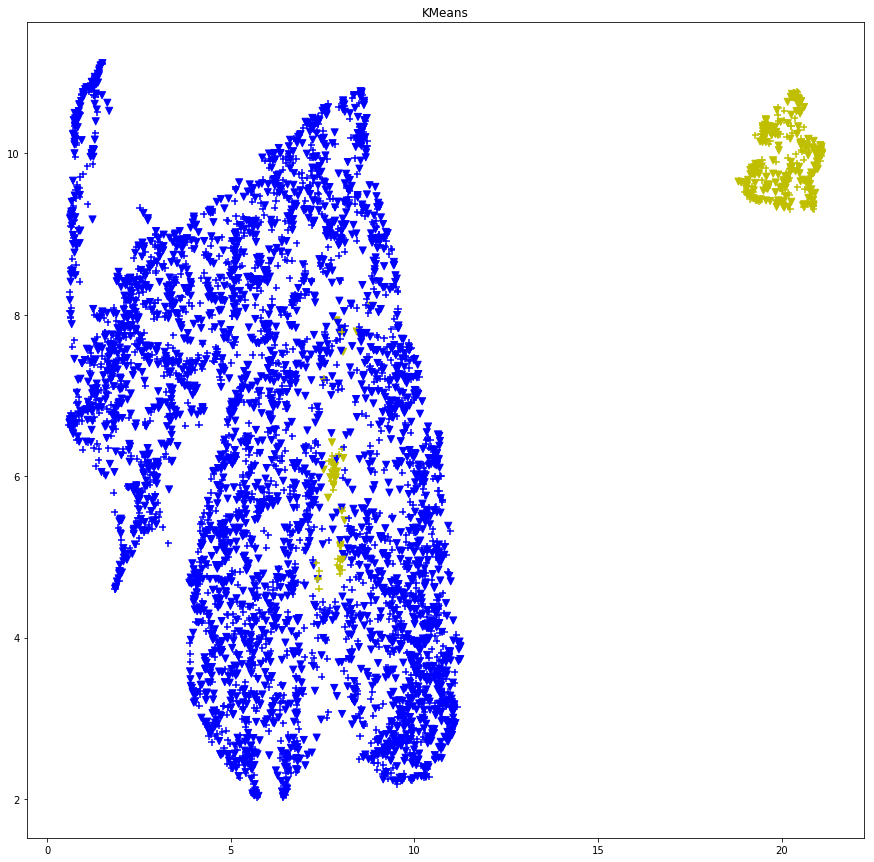

In [117]:
plot_cluster(random_true_X,random_false_X,'PRED')

In [ ]:
type(y_pred)

## Crafts

In [ ]:
# // TODO
# feature_filtered_df = labevent_detailed_df[(labevent_detailed_df.LABEL == 'Blasts')] 
labevent_detailed_df[(labevent_detailed_df.LABEL == 'pH')].sort_values(by='SUBJECT_ID')

In [ ]:
# initiate all user vectors
con_stc_ls = ['min','mean','max','std']
con_stc_ls_len = len(con_stc_ls)

user_vectors = {}
all_users = set(labevent_detailed_df['SUBJECT_ID'].unique())
for user in all_users:
    user_vectors[user] = np.empty([0])
    

In [ ]:
# pick one iteration of continuous label
wbc = labevent_detailed_df[labevent_detailed_df['LABEL']=='WBC']
wbc_agg = wbc.dropna(subset=['VALUENUM']).groupby('SUBJECT_ID')['VALUENUM'].agg(con_stc_ls)
wbc_agg.head()
# wbc_agg[:10]
# wbc[wbc['SUBJECT_ID']==4][:10]

current_users = set(wbc['SUBJECT_ID'].unique())
missed_users = all_users - current_users

for user, row in wbc_agg.iterrows():
    if pd.isnull(row['std']): row['std']=0
    user_vectors[user]=np.append(user_vectors[user],[row[x] for x in con_stc_ls])
for user in missed_users:
    user_vectors[user]=np.append(user_vectors[user],np.full(con_stc_ls_len, np.nan))

In [ ]:
# all_users = labevent_detailed_df['SUBJECT_ID'].unique() 
# print(len(set(all_users)- set(wbc['SUBJECT_ID'].unique())))
# print(len(all_users))
# np.full(3, np.nan)
# np.append(np.array([1]),[2,3])
# user_vectors[5]
# wbc = labevent_detailed_df[labevent_detailed_df['LABEL']=='WBC']
ani_agg.head()


In [ ]:
# pick one iteration of discrete label
ani = labevent_detailed_df[labevent_detailed_df['LABEL']=='Anisocytosis']
ani_agg = ani.dropna(subset=['VALUE']).groupby(['SUBJECT_ID','VALUE'])['LABEL'].agg(['count'])
ani_agg_per = ani_agg.groupby(level=0).apply(lambda x: 100* x/float(x.sum()))
current_users = set(ani['SUBJECT_ID'].unique())
missed_users = all_users - current_users

ani_agg_per.reset_index
ani_matrix = pd.pivot_table(ani_agg_per,values = ['count'],index=['SUBJECT_ID'],columns=['VALUE'])

ani_matrix = ani_matrix.fillna(0)
for user in ani_matrix.index.get_level_values('SUBJECT_ID')[:10]:
    user_vectors[user] = np.append(user_vectors[user],ani_matrix.ix[user].values)
for user in missed_users:
    user_vectors[user]=np.append(user_vectors[user],np.full(ani_matrix.shape[1], np.nan))
# ani_matrix.head() 
# ani_matrix.shape[1]

In [ ]:
final_feature_df = feature_filtered_df[['SUBJECT_ID','CHARTTIME','VALUENUM']]
# Remove Nan data
final_feature_df = final_feature_df[final_feature_df.VALUENUM.notna()]
final_feature_df[:10]

In [ ]:
final_feature_df['CHAR_DATE'] = final_feature_df['CHARTTIME'].dt.date
final_feature_df[:10]

In [ ]:

final_feature_bydate_df = final_feature_df.groupby(['SUBJECT_ID','CHAR_DATE']).agg({"VALUENUM": "mean"})

final_feature_bydate_df = final_feature_bydate_df.reset_index().sort_values(by=['SUBJECT_ID','CHAR_DATE'])

final_feature_bydate_df['SHIFT_DATE'] = final_feature_bydate_df.groupby('SUBJECT_ID')['CHAR_DATE'].apply(lambda i:i.shift(1))
final_feature_bydate_df[:10]

In [ ]:
final_feature_bydate_df['DATE_INTERVAL'] = (final_feature_bydate_df['CHAR_DATE']
                                           - final_feature_bydate_df['SHIFT_DATE']).dt.days

## remove those subjects not in feature dataframe


In [ ]:
final_label_df = final_label_df[final_label_df['SUBJECT_ID'].isin(final_feature_bydate_df['SUBJECT_ID'])]

In [ ]:
subject_label = {}
subject_label = final_label_df.set_index('SUBJECT_ID').to_dict('index')
for key in subject_label:
    subject_label[key] = subject_label[key]['CONGESTIVE_HEART_FAILURE']

In [ ]:
num_attrs = 25
current_vector = np.zeros(num_attrs, dtype=float)
current_index = 0
current_subject = final_feature_bydate_df["SUBJECT_ID"][0]
subject_dict = {}


for index, row in final_feature_bydate_df.iterrows():
    # if not in the begining of a group, increase index by date interval
    if not (pd.isnull(row["DATE_INTERVAL"])):
        current_index += row["DATE_INTERVAL"]
        
    if row["SUBJECT_ID"] != current_subject: 

        subject_dict[current_subject] = current_vector
        current_vector = np.zeros(num_attrs, dtype=float)
        if current_subject not in subject_label:
            subject_label[current_subject]= '0'
        
        current_index = 0
        current_subject = row["SUBJECT_ID"]
        
    if current_index >= 25: continue
    current_vector[int(current_index)]= row["VALUENUM"]

subject_dict[current_subject] = current_vector
if current_subject not in subject_label:
    subject_label[current_subject]='0'

## t-SNE

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

max_train = 5000
train_dict_keys = random.sample(list(subject_dict.keys()), max_train)
## Get X and y
X = np.empty(shape=(max_train,max_attrs))
y = np.empty(shape=(max_train))

i=0
for k in train_dict_keys:
    X[i]=subject_dict[k]
    y[i]=subject_label[k]
    i+=1   
    
X_embedded = TSNE(n_components=2, learning_rate=3000).fit_transform(X)

In [ ]:
plt.figure(figsize=(15, 15))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=y, s=10, alpha = 1)

plt.show()